In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import math

img_path = 'C:/Users/Huai-Uin/Documents/GitHub/1st-DL-CVMarathon/picture/lena.png'
img = cv2.imread(img_path)

## (1)邊緣檢測

比較 Sobel 如果在 uint8 的情況下做會 overflow 的狀況

- cv2.Sobel(src, ddepth, dx, dy[, ksize[, scale[, delta[, borderType]]]])
    - src:輸入圖像
    - ddepth:輸出圖像深度，-1代表與原圖像同深度
    - dx,dy:求導數的階數，一般設定為0,1,2
    - ksize:算子的大小，必須是1,3,5,7,默認為3
    - scale:是缩放導數的比例常數，默認情况下没有伸缩係數，默認為1
    - delta:
    - borderType:

In [2]:
# 轉為灰階圖片
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 對 x 方向以包含負數的資料格式 (cv2.CV_16S) 進行 Sobel 邊緣檢測
img_sobel_x = cv2.Sobel(img_grey, cv2.CV_16S, dx=1, dy=0, ksize=3)
img_sobel_x = cv2.convertScaleAbs(img_sobel_x)

# 對 x 方向直接以非負整數的資料格式 (uint8) 進行 Sobel 邊緣檢測
img_sobel_x_uint8 = cv2.Sobel(img_grey, cv2.CV_8U, dx=1, dy=0, ksize=3)

#　組合 + 顯示圖片
img_show = np.hstack((img_grey, img_sobel_x, img_sobel_x_uint8))
while True:
    # 比較 Sobel 邊緣檢測的過程中針對負數操作的不同產生的差異
    cv2.imshow('Edge Detection', img_show)
    k = cv2.waitKey(0)
    if k == 27:
        cv2.destroyAllWindows()
        break

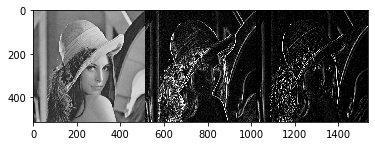

In [3]:
plt.imshow(img_show,cmap='gray')
plt.show()
#sign 16 int 可以檢測由黑道白和白道黑的編距
#unsign 8 int 可以檢測黑到白的邊距

#### 比較一次與兩次計算偏微分的結果

In [4]:
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 求一次導數取得邊緣檢測結果
img_sobel_x = cv2.Sobel(img_grey, cv2.CV_16S, dx=1, dy=0, ksize=3)
img_sobel_x = cv2.convertScaleAbs(img_sobel_x)

# 求二次導數取得邊緣檢測結果
img_sobel_xx = cv2.Sobel(img_grey, cv2.CV_16S, dx=2, dy=0, ksize=3)
img_sobel_xx = cv2.convertScaleAbs(img_sobel_xx)

#　組合 + 顯示圖片
img_show = np.hstack((img_grey, img_sobel_x, img_sobel_xx))
while True:
    cv2.imshow('Edge Detection', img_show)
    k = cv2.waitKey(0)
    if k == 27:
        cv2.destroyAllWindows()
        break

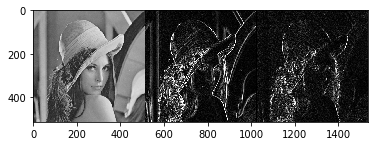

In [5]:
plt.imshow(img_show,cmap='gray')
plt.show()

## SIFT
**SIFT 是一種表徵 (appearance feature)**

基於局部的外觀特徵，進一步考慮到圖片特徵的狀況

- 縮放不變性，旋轉不變性
- 光線與雜訊容忍度高

在 SIFT 演算法中可以了解到如何做關鍵點偵測，並如何抽出 SIFT 特徵來敘述關鍵點
## 尺度不變性
SIFT 主要考慮到的問題之一是尺度

以 corner detector (e.g. Harris) 為例，Filter 可以偵測到範圍以內的角落點，

但是同樣的 pattern 放大後以同樣的 Filter 去偵測就會失敗~ 以為是直線了

![img](https://docs.opencv.org/3.4/sift_scale_invariant.jpg)

SIFT 會基於邊緣檢測抽取特徵，但不是使用前面提過的 Sobel，概念上是 LoG 但是考慮到計算量使用 DoG 做邊緣檢測

- Laplacian of Gaussian (LoG)

先對圖片做 Gaussian Blur 再算二階導數取得邊緣
- Difference of Gaussian (DoG)

圖片經過不同程度的縮放後計算出不同程度的 Gaussian Blur 最後合併得到一個 Gaussian Pyramid，其差值即為 DoG。結果可以視為 LoG 的約略值 (沒有做二階導數)

![img](https://docs.opencv.org/3.4/sift_dog.jpg)

(p.s. 這邊討論的特徵主要是物體的邊緣，而二階導數是個適合的工具來找出邊緣，因此這邊才會以此討論 LoG 與 DoG)

極值偵測
DoG 影像包含多種尺度

接著要針對每個 pixel 判斷是否為極值

判斷範圍 8+18 = 26

- 自己本身周遭的 8 個 pixel
- 同一個 scale 圖片但不同模糊尺度相鄰位置共 9*2=18 個 pixel

\\假如該 pixel 為判斷範圍內的最大/最小值，則將其設為有興趣的關鍵點\\

![img](https://docs.opencv.org/3.4/sift_local_extrema.jpg)

## 關鍵點定位
經過多尺度極值偵測之後，會得到許多候選的關鍵點，其中也包含許多噪音跟邊的關鍵點，需要更進一步根據周遭資訊來修正並過濾關鍵點。

鄰近資料差補:主要根據相鄰資訊來修正極值的位置

過濾不明顯關鍵點:根據計算曲率來判斷是否為不明顯的關鍵點

過濾邊緣關鍵點:根據計算曲率來判斷是否為不明顯的關鍵點

## 方位定向
前面我們定義並過濾了許多關鍵點，但是關鍵點只有包含尺度跟位置

SIFT 還想要保有旋轉不變性，因此要給關鍵點定義一個方向

- 以每 10 度為單位計算周圍的梯度值
- 梯度值最大的方向當作是該關鍵點的主要方向

## 關鍵點描述子
賦與關鍵點位置，尺度，方向確保移動，縮放，旋轉的不變性，還需要額外建立描述子來確保不同光線跟視角也有不變性

- 描述子會正規化成 128 維的特徵向量
- 以關鍵點周圍 16*16 的區域共 4*4 的子區域，計算 8 個方向的直方圖，共 4\4*8 = 128 維的特徵向量
>Note：每個關鍵點都會產生 128 維的特徵，而圖片會產生 N 個關鍵點，也就是會產生 (N, 128) 維度特徵

In [6]:
# 轉灰階圖片
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 建立 SIFT 物件
SIFT_detector = cv2.xfeatures2d.SIFT_create()

# 取得 SIFT 關鍵點位置
keypoints = SIFT_detector.detect(img_gray, None)

#　畫圖 + 顯示圖片
img_show = cv2.drawKeypoints(img_gray, keypoints, img)
while True:
    cv2.imshow('SIFT', img_show)
    k = cv2.waitKey(0)
    if k == 27:
        cv2.destroyAllWindows()
        break

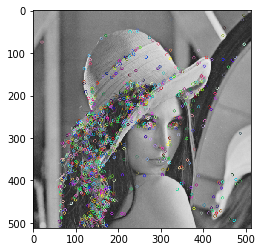

In [7]:
plt.imshow(img_show,cmap='gray')
plt.show()

## 特徵應用
當我們取得特徵之後，就代表我們已經有能力去識別關鍵點的特殊性

在這之後可以接到許多電腦視覺的任務

- 配對：判斷兩張圖片上相同物體的位置
- 辨識：判斷兩張圖片上是否有相同物體
- 全景圖：尋找兩張圖片的相同視角，再經過轉換合成全景圖
- 廣泛的說，SIFT 只是其中一種抽取特徵的方式，這邊會延續上一章節以 SIFT 為例介紹配對的應用。

## Feature Matching
配對會從兩張圖片中的關鍵點中，透過計算其特徵空間上的距離，若小於一個設定的閥值就視為是相同的特徵

在 SIFT 特徵的配對任務中，通常會使用 L2 norm 的方式計算。兩個 128 維向量(敘述子)可以得到一個距離

actually it's similiarity

簡單暴力的配對方法是逐一針對 query image 的關鍵點

對每個 train image 的關鍵點計算 L2 距離

- 取得距離最小的配對
- 取得 k 個最適合的配對(針對每個query都找k個適合的)

這邊為了確保配對的合適性，可以先在計算時取得 k 個配對，在根據距離(ratio test)去過濾不適合的配對

#### ratio test
我們可以尋找 k=2 個最好的 match 方式，透過 ratio test 的方式來過濾一些不適當的配對，因為有時候 query 的關鍵點並不會出現在 train image( 0.7~0.8 is suggested)